In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib
import tensorflow as tf, keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.svm import OneClassSVM


# Load dataset
file_path = "/Users/manasa/Downloads/AnomaData.xlsx"  # Change this if needed
df = pd.read_excel(file_path)

2025-03-13 15:38:13.058400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Display basic info
print("Dataset Shape:", df.shape)
print("\nDataset Info:\n", df.info())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (18398, 62)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    18398 non-null  datetime64[ns]
 1   y       18398 non-null  int64         
 2   x1      18398 non-null  float64       
 3   x2      18398 non-null  float64       
 4   x3      18398 non-null  float64       
 5   x4      18398 non-null  float64       
 6   x5      18398 non-null  float64       
 7   x6      18398 non-null  float64       
 8   x7      18398 non-null  float64       
 9   x8      18398 non-null  float64       
 10  x9      18398 non-null  float64       
 11  x10     18398 non-null  float64       
 12  x11     18398 non-null  float64       
 13  x12     18398 non-null  float64       
 14  x13     18398 non-null  float64       
 15  x14     18398 non-null  float64       
 16  x15     18398 non-null  float64       
 17  x16     18398 non-null 

In [3]:
# Check first few rows
print("\nFirst 5 rows of dataset:")
print(df.head())
print(df.isnull().sum())  # Shows the count of NaNs per column


First 5 rows of dataset:
                 time  y        x1        x2        x3         x4        x5  \
0 1999-05-01 00:00:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1 1999-05-01 00:02:00  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2 1999-05-01 00:04:00  0  0.363848 -4.681394 -4.353147  14.127997 -0.138636   
3 1999-05-01 00:06:00  0  0.301590 -4.758934 -4.023612  13.161566 -0.148142   
4 1999-05-01 00:08:00  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x51        x52       x54  \
0 -20.669883  0.000732 -0.061114  ...  29.984624  10.091721 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  29.984624  10.095871 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  29.984624  10.100265 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  29.984624  10.104660 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  29.984624  10.109054 -4.939414   

         x55        x56       x57       x58       x59       

In [4]:
# Convert time column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Summary statistics
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
                                 time             y            x1  \
count                          18398  18398.000000  18398.000000   
mean   1999-05-15 01:20:42.728557312      0.006740      0.011824   
min              1999-05-01 00:00:00      0.000000     -3.787279   
25%              1999-05-08 03:36:30      0.000000     -0.405681   
50%              1999-05-14 18:39:00      0.000000      0.128245   
75%              1999-05-22 06:01:30      0.000000      0.421222   
max              1999-05-29 00:06:00      1.000000      3.054156   
std                              NaN      0.081822      0.742875   

                 x2            x3            x4            x5            x6  \
count  18398.000000  18398.000000  18398.000000  18398.000000  18398.000000   
mean       0.157986      0.569300     -9.958345      0.006518      2.387533   
min      -17.316550    -18.198509   -322.781610     -1.623988   -279.408440   
25%       -2.158235     -3.537054   -111.378372  

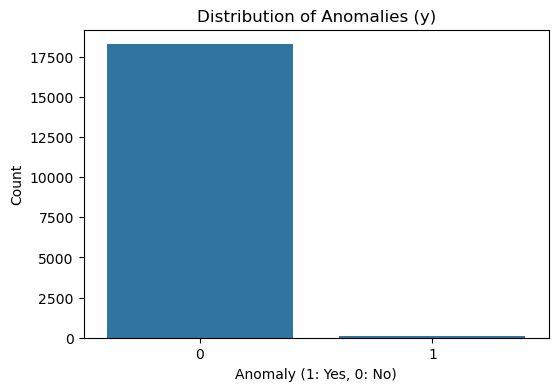

In [5]:
# Distribution of the target variable (y)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['y'])
plt.title("Distribution of Anomalies (y)")
plt.xlabel("Anomaly (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()

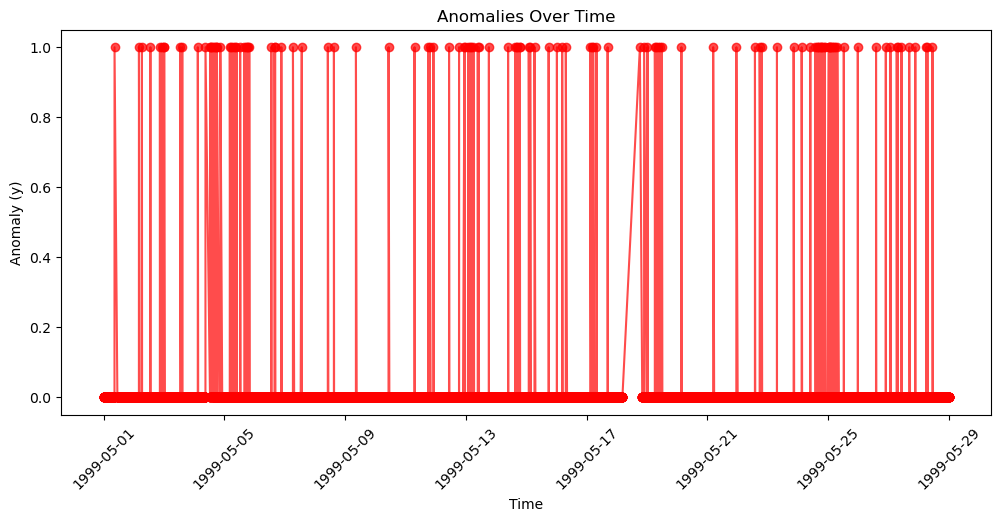

In [6]:
# Visualizing anomalies over time
plt.figure(figsize=(12, 5))
plt.plot(df['time'], df['y'], marker='o', linestyle='-', color='red', alpha=0.7)
plt.title("Anomalies Over Time")
plt.xlabel("Time")
plt.ylabel("Anomaly (y)")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Check correlation between independent variables and y
corr_matrix = df.corr()
top_corr_features = corr_matrix['y'].drop('y').sort_values(ascending=False)[:10]  # Top 10 correlated features
print("\nTop 10 Features Correlated with y:\n", top_corr_features)


Top 10 Features Correlated with y:
 y.1    0.390321
x15    0.058647
x42    0.034149
x9     0.024217
x24    0.023117
x7     0.018346
x4     0.016792
x60    0.016083
x21    0.015817
x46    0.012870
Name: y, dtype: float64


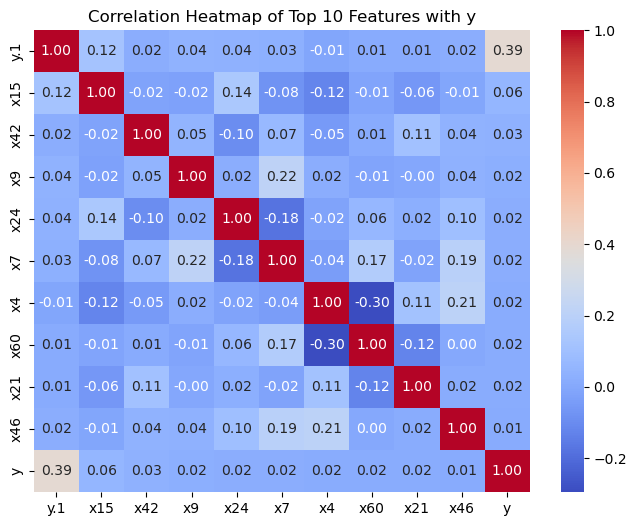

In [12]:
# Heatmap of top 10 correlated features with y
plt.figure(figsize=(8, 6))
sns.heatmap(df[top_corr_features.index.tolist() + ['y']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top 10 Features with y")
plt.show()

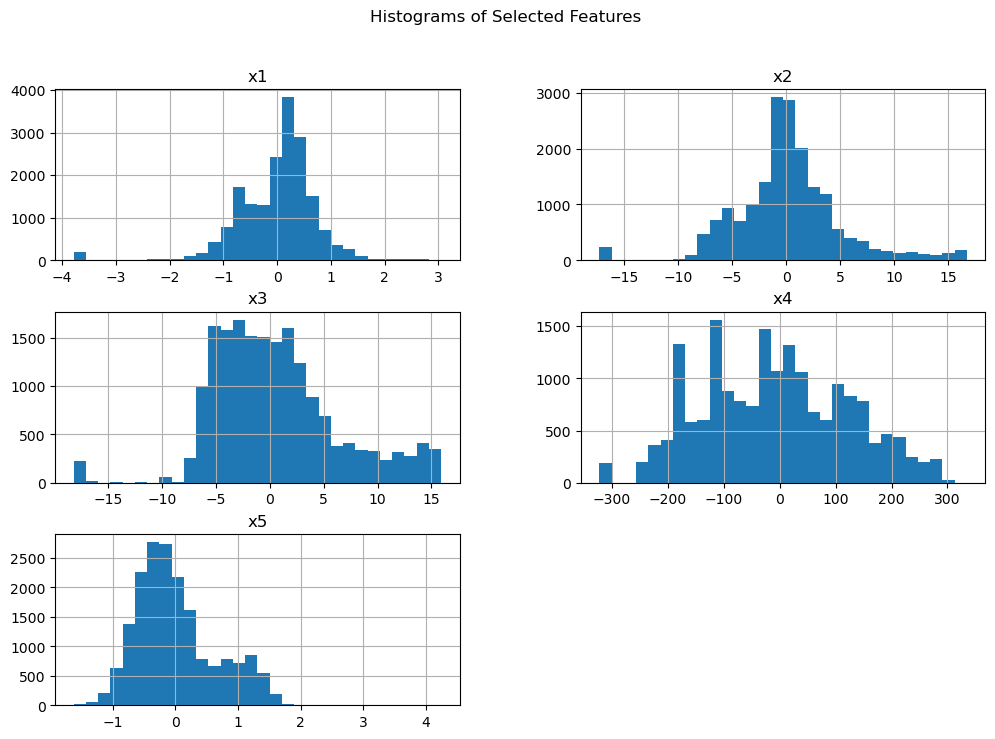

In [16]:
# Histogram for a few independent variables
features_to_plot = ['x1', 'x2', 'x3', 'x4', 'x5']  # Change based on importance
df[features_to_plot].hist(figsize=(12, 8), bins=30)
plt.suptitle("Histograms of Selected Features")
plt.show()

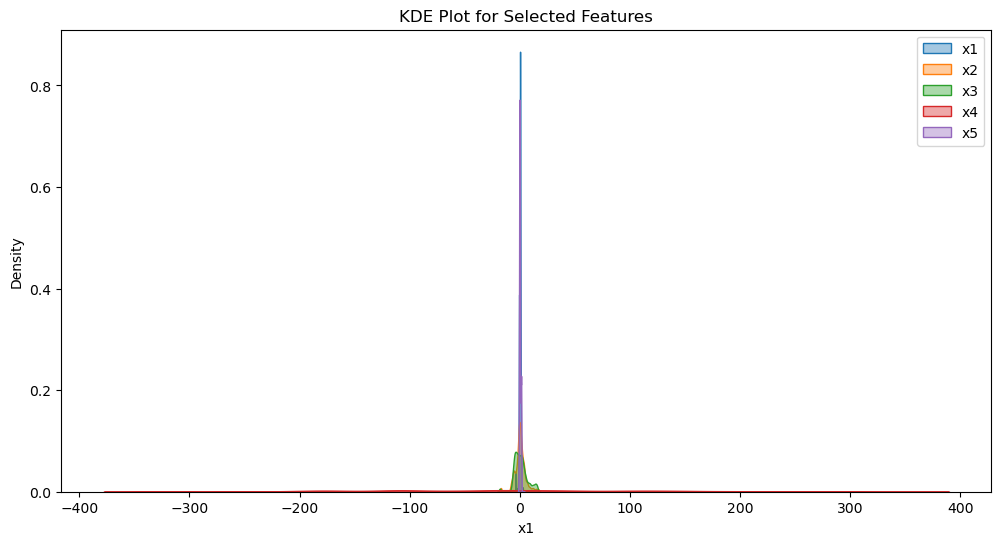

In [19]:
# KDE Plots for selected features
plt.figure(figsize=(12, 6))
for feature in features_to_plot:
    sns.kdeplot(df[feature], label=feature, fill=True, alpha=0.4)
plt.legend()
plt.title("KDE Plot for Selected Features")
plt.show()

In [21]:
# Import necessary libraries
# Step 1: Handling Missing Values
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())
print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset



Missing Values Before Cleaning:
 time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64

Total missing values: 0


In [23]:
# Option 1: Fill missing values with median (robust to outliers)
df.fillna(df.median(), inplace=True)

# Option 2: Drop rows with missing values (uncomment if preferred)
#df.dropna(inplace=True)

In [25]:
print("\nMissing Values After Cleaning:\n", df.isnull().sum())
print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset
y = df['y']
print("Original Class Distribution:\n", y.value_counts())


Missing Values After Cleaning:
 time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64

Total missing values: 0
Original Class Distribution:
 y
0    18274
1      124
Name: count, dtype: int64


In [27]:
# Step 2: Handling Outliers using the Interquartile Range (IQR) method
# Separate anomalies (`y=1`) before applying outlier removal

def remove_outliers_iqr(data, column):
    """ Removes outliers using IQR method for a given column (only for normal data `y=0`) """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Separate anomalies (`y=1`) before applying outlier removal
df_anomalies = df[df['y'] == 1].copy()  # Store anomalies safely
df_normal = df[df['y'] == 0].copy()  # Store normal data separately

# Apply outlier removal ONLY to normal data (`y=0`)
for col in df_normal.columns:
    if col not in ['y', 'time']:  # Exclude target and time variable
        df_normal = remove_outliers_iqr(df_normal, col)

# Recombine normal data and anomalies (ensuring no anomalies are lost)
df = pd.concat([df_normal, df_anomalies], ignore_index=True)


print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset
y = df['y']
print("Original Class Distribution:\n", y.value_counts())


Total missing values: 0
Original Class Distribution:
 y
0    2347
1     124
Name: count, dtype: int64


In [30]:
#Step 3: Standardization using Min-Max Scaling (Feature Scaling)

# Apply MinMaxScaler (ensuring consistency for Autoencoder & SVM)
scaler = MinMaxScaler()
# Exclude 'y' (target) and 'time' from scaling
features_to_scale = [col for col in df.columns if col not in ['y', 'time']]

df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\nData Standardization Completed: Features Scaled to Range [0,1]")

# Display final cleaned dataset
print(df.head())
print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset
print("Original Class Distribution:\n", y.value_counts())


Data Standardization Completed: Features Scaled to Range [0,1]
                 time  y        x1        x2        x3        x4        x5  \
0 1999-05-02 05:32:00  0  0.479500  0.521609  0.620252  0.713695  0.261556   
1 1999-05-02 05:42:00  0  0.464167  0.531231  0.632819  0.713695  0.278669   
2 1999-05-02 09:08:00  0  0.458498  0.661135  0.683706  0.763623  0.224652   
3 1999-05-02 09:16:00  0  0.444226  0.644600  0.692506  0.781612  0.210051   
4 1999-05-02 09:24:00  0  0.451557  0.650660  0.693170  0.000000  0.205830   

         x6        x7        x8  ...       x51       x52       x54       x55  \
0  0.698707  0.457356  0.352118  ...  0.188073  0.938611  0.886273  0.336280   
1  0.692676  0.455321  0.346788  ...  0.188073  0.937900  0.885525  0.327936   
2  0.769592  0.455321  0.363032  ...  0.188073  0.929536  0.895204  0.320447   
3  0.796302  0.445769  0.363032  ...  0.188073  0.929536  0.895170  0.329082   
4  0.821848  0.398297  0.354910  ...  0.188073  0.929536  0.895136 

In [34]:
#Feature engineering
#Log Transformation (For Skewed Data)
for col in df.columns:
    if col.startswith('x') and df[col].min() > 0:  # Avoid log(0) error
        df[f'{col}_log'] = np.log(df[col] + 1)

print("\nLog Transformation Applied to Numeric Features")


df[df['y'] == 1]
print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset
print("Original Class Distribution:\n", y.value_counts())


Log Transformation Applied to Numeric Features

Total missing values: 0
Original Class Distribution:
 y
0    2347
1     124
Name: count, dtype: int64


In [36]:
df[df['y'] == 1]

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x54,x55,x56,x57,x58,x59,x60,y.1
2347,1999-05-01 08:38:00,1,0.699881,0.140302,0.215357,0.515094,0.179242,0.764820,0.407850,0.314546,...,0.188073,1.000000,0.149818,0.195309,0.628470,0.926753,0.911409,1.000000,0.634906,1.0
2348,1999-05-02 04:02:00,1,0.449400,0.186861,0.006922,0.000000,0.128476,0.799908,0.445769,0.306423,...,0.188073,0.945004,0.891913,0.349090,0.388141,0.840216,0.819148,0.501203,0.641133,0.0
2349,1999-05-02 06:24:00,1,0.462116,0.586612,0.646059,0.702216,0.153023,0.681228,0.464873,0.403150,...,0.188073,0.934916,0.881141,0.306471,0.304232,0.737882,0.829699,0.507133,0.637551,0.0
2350,1999-05-02 13:08:00,1,0.448017,0.648728,0.489099,0.767235,0.246811,0.740276,0.412625,0.391063,...,0.188073,0.929536,0.894184,0.298439,0.351621,0.675047,0.848657,0.614108,0.589023,0.0
2351,1999-05-02 20:42:00,1,0.385147,0.562424,0.547973,0.561092,0.096738,0.758480,0.322458,0.387152,...,0.188073,0.929536,0.899881,0.367394,0.360419,0.730701,0.958564,0.513756,0.553207,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,1999-05-27 16:22:00,1,0.560182,0.422974,0.335740,0.637298,0.182189,0.919396,0.369931,0.370908,...,0.188073,0.930123,0.779004,0.539954,0.671543,0.693000,0.790636,0.118763,0.173013,0.0
2467,1999-05-27 21:12:00,1,0.582196,0.785968,0.668785,0.616719,0.344838,0.867898,0.360377,0.435392,...,0.188073,0.933820,0.761956,0.562516,0.642755,0.657091,0.802148,0.211251,0.164752,0.0
2468,1999-05-28 05:54:00,1,0.600986,0.697062,0.574099,0.628636,0.186711,0.895602,0.303644,0.330544,...,0.095469,0.934898,0.768122,0.521204,0.657957,0.707362,0.840440,0.246385,0.215314,0.0
2469,1999-05-28 06:50:00,1,0.577645,0.122507,0.002665,0.792040,0.215802,0.910010,0.398297,0.363032,...,0.077261,0.934898,0.869939,0.545694,0.428031,0.671453,0.820856,0.179882,0.202246,0.0


In [41]:
#Model training

# Convert time column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Drop non-feature columns
X = df.drop(columns=['y', 'time'])  # Features (Independent Variables)
y = df['y']  # Target (1 = Anomaly, 0 = Normal)

# Split into training and test sets (Before applying SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset
print("Original Class Distribution:\n", y.value_counts())

# Combine X and y back together for train and test sets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save train and test data to Excel files
train_data.to_excel("train_data.xlsx", index=False)
test_data.to_excel("test_data.xlsx", index=False)

# Store a copy of the dataset before modifications (to avoid unintended changes)
X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = y_train.copy()
y_test_original = y_test.copy()

### **🔹 Model 1: Isolation Forest**
X_train = X_train_original.copy()  # Reset variables
X_test = X_test_original.copy()


#Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
isolation_forest.fit(X_train)
iso_preds = isolation_forest.predict(X_test)
iso_preds = np.where(iso_preds == -1, 1, 0)  # Convert -1 (anomaly) to 1

# Evaluate Isolation Forest
print("\n🔹 Isolation Forest Results")
print(classification_report(y_test, iso_preds))
print(f"ROC-AUC Score: {roc_auc_score(y_test, iso_preds):.4f}")

# Save the model for future inference
import joblib
joblib.dump(isolation_forest, "isolation_forest_model.pkl")

print("\nModel Training Completed. Model saved as 'isolation_forest_model.pkl'.")
print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset



Total missing values: 0
Original Class Distribution:
 y
0    2347
1     124
Name: count, dtype: int64

🔹 Isolation Forest Results
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       470
           1       1.00      0.16      0.28        25

    accuracy                           0.96       495
   macro avg       0.98      0.58      0.63       495
weighted avg       0.96      0.96      0.94       495

ROC-AUC Score: 0.5800

Model Training Completed. Model saved as 'isolation_forest_model.pkl'.

Total missing values: 0


In [43]:
print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset


Total missing values: 0


In [45]:
df[df['y'] == 1]

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x54,x55,x56,x57,x58,x59,x60,y.1
2347,1999-05-01 08:38:00,1,0.699881,0.140302,0.215357,0.515094,0.179242,0.764820,0.407850,0.314546,...,0.188073,1.000000,0.149818,0.195309,0.628470,0.926753,0.911409,1.000000,0.634906,1.0
2348,1999-05-02 04:02:00,1,0.449400,0.186861,0.006922,0.000000,0.128476,0.799908,0.445769,0.306423,...,0.188073,0.945004,0.891913,0.349090,0.388141,0.840216,0.819148,0.501203,0.641133,0.0
2349,1999-05-02 06:24:00,1,0.462116,0.586612,0.646059,0.702216,0.153023,0.681228,0.464873,0.403150,...,0.188073,0.934916,0.881141,0.306471,0.304232,0.737882,0.829699,0.507133,0.637551,0.0
2350,1999-05-02 13:08:00,1,0.448017,0.648728,0.489099,0.767235,0.246811,0.740276,0.412625,0.391063,...,0.188073,0.929536,0.894184,0.298439,0.351621,0.675047,0.848657,0.614108,0.589023,0.0
2351,1999-05-02 20:42:00,1,0.385147,0.562424,0.547973,0.561092,0.096738,0.758480,0.322458,0.387152,...,0.188073,0.929536,0.899881,0.367394,0.360419,0.730701,0.958564,0.513756,0.553207,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,1999-05-27 16:22:00,1,0.560182,0.422974,0.335740,0.637298,0.182189,0.919396,0.369931,0.370908,...,0.188073,0.930123,0.779004,0.539954,0.671543,0.693000,0.790636,0.118763,0.173013,0.0
2467,1999-05-27 21:12:00,1,0.582196,0.785968,0.668785,0.616719,0.344838,0.867898,0.360377,0.435392,...,0.188073,0.933820,0.761956,0.562516,0.642755,0.657091,0.802148,0.211251,0.164752,0.0
2468,1999-05-28 05:54:00,1,0.600986,0.697062,0.574099,0.628636,0.186711,0.895602,0.303644,0.330544,...,0.095469,0.934898,0.768122,0.521204,0.657957,0.707362,0.840440,0.246385,0.215314,0.0
2469,1999-05-28 06:50:00,1,0.577645,0.122507,0.002665,0.792040,0.215802,0.910010,0.398297,0.363032,...,0.077261,0.934898,0.869939,0.545694,0.428031,0.671453,0.820856,0.179882,0.202246,0.0


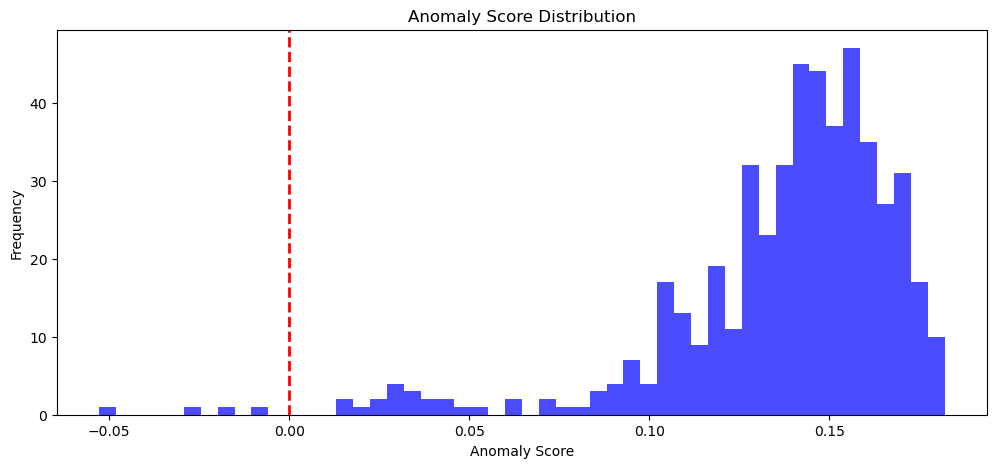

In [50]:
# **Visualizing Anomaly Scores**
import matplotlib.pyplot as plt

# Get anomaly scores
df_test = X_test.copy()
df_test['anomaly_score'] = isolation_forest.decision_function(X_test)
df_test['y_true'] = y_test

# Plot anomaly scores
plt.figure(figsize=(12, 5))
plt.hist(df_test['anomaly_score'], bins=50, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


In [52]:
# Hyperparamter tuning
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_samples': [0.6, 0.8, 1.0],  # Fraction of data used per tree
    'contamination': [0.01, 0.02, 0.05],  # Proportion of anomalies
    'max_features': [0.5, 0.75, 1.0]  # Fraction of features per tree
}

# Initialize Isolation Forest
isolation_forest = IsolationForest(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(isolation_forest, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print best hyperparameters
print("\nBest Hyperparameters Found:")
print(grid_search.best_params_)

# Save the best model
joblib.dump(best_model, "optimized_isolation_forest.pkl")

print("\nHyperparameter tuning completed. Optimized model saved as 'optimized_isolation_forest.pkl'.")


Best Hyperparameters Found:
{'contamination': 0.01, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 100}

Hyperparameter tuning completed. Optimized model saved as 'optimized_isolation_forest.pkl'.


In [53]:
# Train Isolation Forest with optimized hyperparameters
optimized_model = IsolationForest(
    n_estimators=100, 
    max_samples=0.6, 
    contamination=0.005, 
    max_features=0.5, 
    random_state=42
)

# Fit the model on the training data
optimized_model.fit(X_train)

# Print Important Model Parameters
print("\nImportant Parameters of Optimized Isolation Forest Model:")
print(f"n_estimators: {optimized_model.n_estimators}")
print(f"max_samples: {optimized_model.max_samples}")
print(f"contamination: {optimized_model.contamination}")
print(f"max_features: {optimized_model.max_features}")
print(f"random_state: {optimized_model.random_state}")
print("\nTotal missing values:", df.isnull().sum().sum())  # Total NaNs in the dataset


Important Parameters of Optimized Isolation Forest Model:
n_estimators: 100
max_samples: 0.6
contamination: 0.005
max_features: 0.5
random_state: 42

Total missing values: 0


In [54]:
# Predict anomalies on the test set
y_pred = optimized_model.predict(X_test)

# Convert Isolation Forest outputs (-1 for anomaly, 1 for normal) to binary (1 for anomaly, 0 for normal)
y_pred = np.where(y_pred == -1, 1, 0)

# **Fix: Check if test set contains both classes before calculating ROC-AUC**
if len(set(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred)
else:
    roc_auc = "N/A (Only one class present in y_test)"

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print results
print("\nUpdated Model Validation Results After Hyperparameter Tuning:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc}")
print("\nClassification Report:\n", classification_rep)

# Save the improved model
joblib.dump(optimized_model, "optimized_isolation_forest.pkl")

print("\nModel re-evaluated and saved as 'optimized_isolation_forest.pkl'.")


Updated Model Validation Results After Hyperparameter Tuning:
Accuracy: 0.9515
ROC-AUC Score: 0.52

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       470
           1       1.00      0.04      0.08        25

    accuracy                           0.95       495
   macro avg       0.98      0.52      0.53       495
weighted avg       0.95      0.95      0.93       495


Model re-evaluated and saved as 'optimized_isolation_forest.pkl'.


In [58]:
### **🔹 Model 2: SVM Model** 
X_train = X_train_original.copy()  # Reset variables
X_test = X_test_original.copy()
# Train One-Class SVM on only normal samples (y=0)
normal_data = X_train[y_train == 0]  # Use only normal samples for training

# Initialize One-Class SVM
one_class_svm = OneClassSVM(kernel="rbf", gamma='scale', nu=0.01)  # nu = contamination level

# Fit the model
one_class_svm.fit(normal_data)

# Predict anomalies on the test set
y_pred = one_class_svm.predict(X_test)

# Convert One-Class SVM outputs (-1 for anomaly, 1 for normal) to binary (1 for anomaly, 0 for normal)
y_pred = np.where(y_pred == -1, 1, 0)

# **Fix: Check if test set contains both classes before calculating ROC-AUC**
if len(set(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred)
else:
    roc_auc = "N/A (Only one class present in y_test)"

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print results
print("\nOne-Class SVM Model Validation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc}")
print("\nClassification Report:\n", classification_rep)

# Save the trained model
import joblib
joblib.dump(one_class_svm, "one_class_svm_model.pkl")

print("\nModel trained and saved as 'one_class_svm_model.pkl'.")




One-Class SVM Model Validation Results:
Accuracy: 0.9798
ROC-AUC Score: 0.9325531914893617

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       470
           1       0.76      0.88      0.81        25

    accuracy                           0.98       495
   macro avg       0.88      0.93      0.90       495
weighted avg       0.98      0.98      0.98       495


Model trained and saved as 'one_class_svm_model.pkl'.


In [60]:
### **🔹 Model 2: Autoencoder Model** 
X_train = X_train_original.copy()  # Reset variables
X_test = X_test_original.copy()
# Train Autoencoder on only normal samples (y=0)
X_train_normal = X_train[y_train == 0]

# Autoencoder Architecture
input_dim = X_train.shape[1]

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

# Bottleneck (latent representation)
bottleneck = Dense(16, activation='relu')(encoded)

# Define the decoder
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Output layer

# Create Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Get reconstruction error for all test samples
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Set threshold for anomalies (95th percentile of normal reconstruction errors)
threshold = np.percentile(reconstruction_error[y_test == 0], 95)

# Predict anomalies
y_pred = (reconstruction_error > threshold).astype(int)

# **Fix: Check if test set contains both classes before calculating ROC-AUC**
if len(set(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred)
else:
    roc_auc = "N/A (Only one class present in y_test)"

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print results
print("\nAutoencoder Model Validation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc}")
print("\nClassification Report:\n", classification_rep)

# Save the trained autoencoder model
autoencoder.save("autoencoder_model.h5")
print("\nModel trained and saved as 'autoencoder_model.h5'.")

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0606 - val_loss: 0.0166
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0114
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0077
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - val_lo


Autoencoder Model Validation Results:
Accuracy: 0.9455
ROC-AUC Score: 0.914468085106383

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       470
           1       0.48      0.88      0.62        25

    accuracy                           0.95       495
   macro avg       0.74      0.91      0.80       495
weighted avg       0.97      0.95      0.95       495


Model trained and saved as 'autoencoder_model.h5'.


In [61]:
df.to_excel("processed_data.xlsx", index=False)
